/tmp/ipython-input-620345044.py:243: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  mm_lines=[]; cmap_mm=cm.get_cmap("Greens", N_MARKET_MAKERS+2)
/tmp/ipython-input-620345044.py:247: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  agent_lines=[]; cmap_ag=cm.get_cmap("tab10", max(3, N_AGENTS))
/tmp/ipython-input-620345044.py:273: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  flow_lines=[]; flow_cmap=cm.get_cmap("tab10", max(3, N_AGENTS))
/tmp/ipython-input-620345044

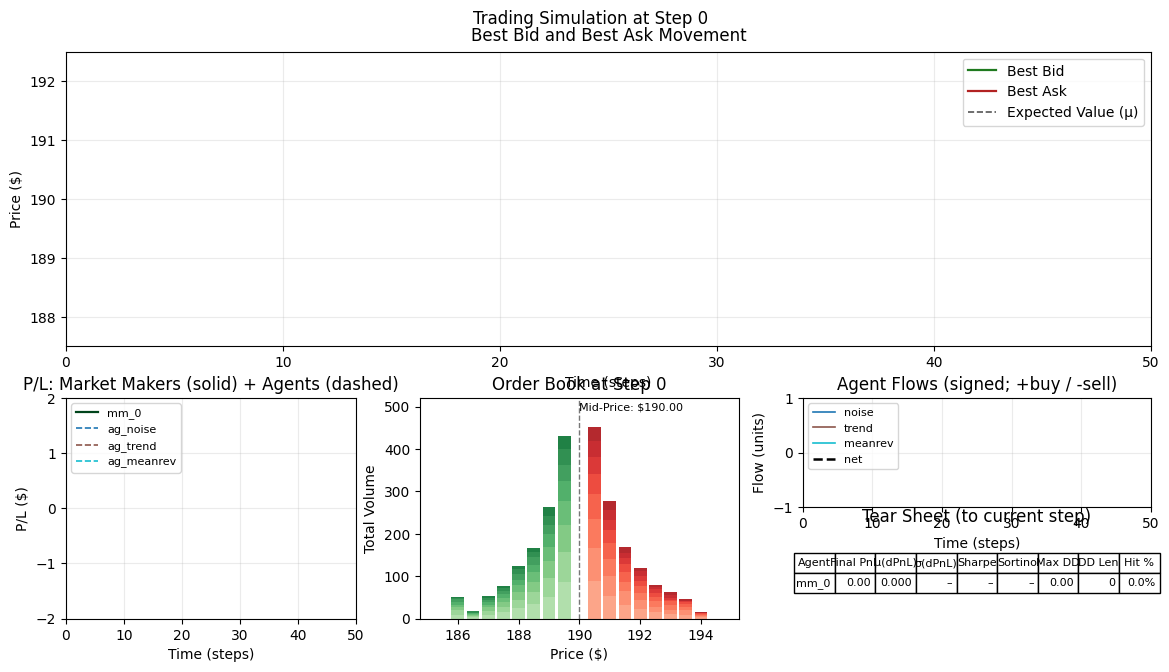

In [13]:
# ==========================================
# Trading Simulation — Mean-Reverting Price + Transient Impact
#  • OU-style mean reversion of mid to a moving anchor (mu)
#  • Transient (decaying) impact from net order flow (market resiliency)
#  • Liquidity-taker agents + Market Makers with unequal flow shares
#  • Live panels: Price, P/L (MMs solid + Agents dashed), Order Book, Agent Flows, Tear Sheet
#  • Inline animation embed (set EMBED_INLINE=True)
# ==========================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, PillowWriter, FFMpegWriter
from matplotlib.gridspec import GridSpec, GridSpecFromSubplotSpec
from matplotlib import cm
from IPython.display import HTML, Image, display

# ---------- Playback / Export ----------
HOLD_FRAMES   = 2
INTERVAL_MS   = 60
GIF_FPS       = 8
EMBED_INLINE  = False   # show animation inline in notebooks
SAVE_GIF      = False
SAVE_MP4      = False
SAVE_CSV      = False
SAVE_PNG      = False
OUT_GIF = "/mnt/trading_sim.gif"
OUT_MP4 = "/mnt/trading_sim.mp4"
OUT_CSV = "/mnt/tearsheet.csv"
OUT_PNG = "/mnt/tearsheet.png"

# ---------- Model ----------
SEED   = 42
N_STEPS= 350
DT     = 1/60
MID0   = 190.0
SIGMA  = 0.5          # exogenous noise
DRIFT  = 0.02

# Mean-reverting price (Ornstein–Uhlenbeck pull to EMA)
K_PRICE_MR = 3      # strength of reversion per time unit (HL ≈ ln(2)/K ≈ 0.385 time units)
# Transient impact (resiliency): decaying state that carries recent flow impact
IMP_DECAY  = 0.975    # per step decay (HL ≈ ln(2)/ln(1/IMP_DECAY) ≈ 27 steps)
IMP_GAIN   = 0.04     # scale of flow contribution to impact state
FLOW_SCALE = 80.0     # tanh saturation for very large flows
KAPPA_IMPACT = 0.0    # set to 0.0 because transient impact replaces permanent impact

# Spread / book shape
SPREAD_BASE  = 1.2
SPREAD_NOISE = 0.6
N_LEVELS     = 8
TICK         = 0.5
DEPTH_SCALE  = 80.0
DEPTH_DECAY  = 0.65

# Market makers
N_MARKET_MAKERS = 1
INV_MR          = 0.65   # faster flattening helps survival (0.6–0.9 sensible)
INV_NOISE       = 0.00   # tiny idiosyncratic fills so lines diverge
SPREAD_CAPTURE  = 0.95   # maker edge proxy per unit traded
MM_RISK_LAMBDA  = 0.0    # optional quadratic inventory penalty; try 1e-3 if needed
MM_FLOW_FRACTION = 0.25   # maker only absorbs 50% of net flow


# Liquidity takers (agents that send market orders)
USE_AGENT_NOISE  = True
USE_AGENT_TREND  = True
USE_AGENT_MEANRV = True
USE_AGENT_TWAP   = False
USE_AGENT_BLOCK  = False

NOISE_SCALE   = 4.0
TREND_BETA    = 25.0   # ↓ from 60 to ease one-way trends
TREND_DECAY   = 0.90
MEANRV_BETA   = 70.0   # ↑ to add stabilizing flow
MEANRV_DECAY  = 0.90
TWAP_TOTAL    = 240.0
BLOCK_PROB    = 0.02
BLOCK_SIZE    = 100.0
TAKER_PENALTY = 0.2   # takers “pay the spread”: cost per unit traded × spread

RNG = np.random.default_rng(SEED)
COL_BID, COL_ASK, COL_MU = "#1f7a1f", "#b22222", "#555555"

# ---------- Agent roster ----------
agent_names = []
if USE_AGENT_NOISE:  agent_names.append("noise")
if USE_AGENT_TREND:  agent_names.append("trend")
if USE_AGENT_MEANRV: agent_names.append("meanrev")
if USE_AGENT_TWAP:   agent_names.append("twap")
if USE_AGENT_BLOCK:  agent_names.append("block")
N_AGENTS = len(agent_names)

# ---------- Series ----------
mid    = np.empty(N_STEPS)
mu     = np.empty(N_STEPS)
spread = np.empty(N_STEPS)
best_bid = np.empty(N_STEPS)
best_ask = np.empty(N_STEPS)

inv  = np.zeros((N_STEPS, N_MARKET_MAKERS))
pnl  = np.zeros((N_STEPS, N_MARKET_MAKERS))

flows    = np.zeros((N_STEPS, N_AGENTS))   # per-agent signed flow (+ buy, - sell)
net_flow = np.zeros(N_STEPS)

agent_inv = np.zeros((N_STEPS, N_AGENTS))
agent_pnl = np.zeros((N_STEPS, N_AGENTS))

# Unequal MM flow shares + slight per-MM edge so lines diverge
mm_weights = RNG.dirichlet(0.8 * np.ones(N_MARKET_MAKERS))
mm_edge    = SPREAD_CAPTURE * (0.8 + 0.4*RNG.random(N_MARKET_MAKERS))

# ---------- Order book helpers ----------
level_offsets = np.arange(1, N_LEVELS+1)
level_weights = (DEPTH_DECAY ** (level_offsets-1))
def gen_book_sizes():
    base = DEPTH_SCALE * level_weights
    noise = RNG.gamma(shape=2.0, scale=2.0, size=N_LEVELS)
    return np.maximum(0, base + noise - 2.5)
def price_levels_for_step(t):
    m = mid[t]
    return m - level_offsets*TICK, m + level_offsets*TICK

# ---------- Tear sheet helpers ----------
def max_drawdown(curve):
    peak = np.maximum.accumulate(curve); dd = curve - peak
    dur = 0; md = 0
    for i in range(len(curve)):
        if curve[i] == peak[i]: dur = 0
        else: dur += 1; md = max(md, dur)
    return dd.min(), md

def perf_stats(curve):
    d = np.diff(curve, prepend=curve[0])
    mu_ = float(np.mean(d))
    sig = float(np.std(d, ddof=1)) if len(d) > 1 else np.nan
    sharpe  = (mu_/sig) if sig and sig > 0 else np.nan
    dn = d[d < 0]; dstd = float(np.std(dn, ddof=1)) if dn.size > 0 else np.nan
    sortino = (mu_/dstd) if dstd and dstd > 0 else np.nan
    mdd, mdl = max_drawdown(curve); hit = float(np.mean(d > 0)) if len(d) > 0 else np.nan
    return {"final_pnl": curve[-1], "mu_dPnL": mu_, "sigma_dPnL": sig, "sharpe": sharpe,
            "sortino": sortino, "max_dd": mdd, "dd_len": int(mdl), "hit_rate": hit}

def render_tearsheet(ax, pnl_upto, n_mm):
    cols = ["Agent","Final PnL","μ(dPnL)","σ(dPnL)","Sharpe","Sortino","Max DD","DD Len","Hit %"]
    rows = []
    for i in range(n_mm):
        s = perf_stats(pnl_upto[:, i])
        rows.append([f"mm_{i}",
                     f"{s['final_pnl']:.2f}",
                     f"{s['mu_dPnL']:.3f}",
                     f"{s['sigma_dPnL']:.3f}" if np.isfinite(s['sigma_dPnL']) else "–",
                     f"{s['sharpe']:.2f}" if np.isfinite(s['sharpe']) else "–",
                     f"{s['sortino']:.2f}" if np.isfinite(s['sortino']) else "–",
                     f"{s['max_dd']:.2f}", f"{s['dd_len']}", f"{100*s['hit_rate']:.1f}%"])
    ax.clear(); ax.axis("off")
    ax.set_title("Tear Sheet (to current step)", pad=4)
    tbl = ax.table(cellText=rows, colLabels=cols, loc="center")
    tbl.auto_set_font_size(False); tbl.set_fontsize(8); tbl.scale(1.05, 1.2)

# ---------- Simulate ----------
mid[0] = MID0; mu[0] = MID0
spread[0] = SPREAD_BASE + abs(RNG.normal(0, SPREAD_NOISE))
best_bid[0] = mid[0] - 0.5*spread[0]; best_ask[0] = mid[0] + 0.5*spread[0]

ema_tr, ema_mr = 0.0, 0.0
twap_rem = TWAP_TOTAL
impact_state = 0.0  # transient impact buffer

for t in range(1, N_STEPS):
    # spread & moving anchor
    spread[t] = max(0.01, SPREAD_BASE + RNG.normal(0, SPREAD_NOISE))
    mu[t]     = 0.98*mu[t-1] + 0.02*mid[t-1]

    # agent flows (+ buy, - sell)
    f = 0
    last_ret = (mid[t-1] - mid[t-2]) if t >= 2 else 0.0
    if USE_AGENT_NOISE:
        flows[t, f] = RNG.normal(0.0, NOISE_SCALE); f += 1
    if USE_AGENT_TREND:
        ema_tr = TREND_DECAY*ema_tr + (1-TREND_DECAY)*last_ret
        flows[t, f] = TREND_BETA * np.tanh(ema_tr / max(1e-9, SPREAD_BASE)); f += 1
    if USE_AGENT_MEANRV:
        ema_mr = MEANRV_DECAY*ema_mr + (1-MEANRV_DECAY)*last_ret
        flows[t, f] = -MEANRV_BETA * np.tanh(ema_mr / max(1e-9, SPREAD_BASE)); f += 1
    if USE_AGENT_TWAP:
        step_slice   = TWAP_TOTAL / N_STEPS
        twf          = np.sign(twap_rem) * min(abs(twap_rem), step_slice)
        flows[t, f]  = twf; twap_rem -= twf; f += 1
    if USE_AGENT_BLOCK:
        flows[t, f]  = (RNG.choice([BLOCK_SIZE, -BLOCK_SIZE]) if RNG.uniform() < BLOCK_PROB else 0.0); f += 1

    net_flow[t] = flows[t].sum()

    # price: drift + exogenous noise + transient impact + OU pull to mu
    shock      = RNG.normal(0, SIGMA)
    flow_shock = IMP_GAIN * np.tanh(net_flow[t] / FLOW_SCALE)
    impact_state = IMP_DECAY * impact_state + flow_shock
    mr_pull    = K_PRICE_MR * (mu[t-1] - mid[t-1]) * DT
    mid[t]     = mid[t-1] + DRIFT*DT + shock + (KAPPA_IMPACT*net_flow[t]) + impact_state + mr_pull

    # quotes from consolidated book
    best_bid[t] = mid[t] - 0.5*spread[t]
    best_ask[t] = mid[t] + 0.5*spread[t]

    # market makers take opposite side, with unequal shares + tiny idio noise
    dP = mid[t] - mid[t-1]
    for i in range(N_MARKET_MAKERS):
        dInv_mm   = -MM_FLOW_FRACTION * mm_weights[i] * net_flow[t] + RNG.normal(0, INV_NOISE)
        inv[t, i] = INV_MR*inv[t-1, i] + dInv_mm
        pnl[t, i] = (pnl[t-1, i]
                     + inv[t-1, i]*dP
                     + mm_edge[i]*abs(dInv_mm)*spread[t]
                     - MM_RISK_LAMBDA*(inv[t-1, i]**2)*DT)  # optional penalty

    # takers accumulate inventory; MTM and pay cross cost
    for k in range(N_AGENTS):
        dInv_ag        = flows[t, k]
        agent_inv[t,k] = agent_inv[t-1,k] + dInv_ag
        agent_pnl[t,k] = agent_pnl[t-1,k] + agent_inv[t-1,k]*dP - TAKER_PENALTY*abs(dInv_ag)*spread[t]

# ---------- Figure & axes ----------
plt.close("all")
fig = plt.figure(figsize=(14, 7))
gs  = GridSpec(nrows=2, ncols=3, height_ratios=[2.0, 1.5], width_ratios=[1.0, 1.1, 1.2], figure=fig)
ax_top  = fig.add_subplot(gs[0, :])
ax_pnl  = fig.add_subplot(gs[1, 0])
ax_book = fig.add_subplot(gs[1, 1])
gs_right = GridSpecFromSubplotSpec(2, 1, subplot_spec=gs[1, 2], height_ratios=[1.2, 1.0])
ax_flow = fig.add_subplot(gs_right[0, 0])
ax_tear = fig.add_subplot(gs_right[1, 0]); ax_tear.axis("off")

# Top: price
(line_bid,) = ax_top.plot([], [], lw=1.6, color=COL_BID, label="Best Bid")
(line_ask,) = ax_top.plot([], [], lw=1.6, color=COL_ASK, label="Best Ask")
(line_mu ,) = ax_top.plot([], [], lw=1.2, color=COL_MU, ls="--", label="Expected Value (μ)")
ax_top.set_title("Best Bid and Best Ask Movement", pad=8)
ax_top.set_xlabel("Time (steps)"); ax_top.set_ylabel("Price ($)")
ax_top.legend(loc="upper right"); ax_top.grid(True, alpha=0.25)

# PnL panel — MMs (solid greens) + Agents (dashed, tab10)
mm_lines=[]; cmap_mm=cm.get_cmap("Greens", N_MARKET_MAKERS+2)
for i in range(N_MARKET_MAKERS):
    (ln,) = ax_pnl.plot([], [], lw=1.6, label=f"mm_{i}", color=cmap_mm(i+2))
    mm_lines.append(ln)
agent_lines=[]; cmap_ag=cm.get_cmap("tab10", max(3, N_AGENTS))
for k, name in enumerate(agent_names):
    (ln,) = ax_pnl.plot([], [], lw=1.2, ls="--", label=f"ag_{name}", color=cmap_ag(k))
    agent_lines.append(ln)
ax_pnl.set_title("P/L: Market Makers (solid) + Agents (dashed)", pad=6)
ax_pnl.set_xlabel("Time (steps)"); ax_pnl.set_ylabel("P/L ($)")
ax_pnl.legend(loc="upper left", ncols=1, fontsize=8); ax_pnl.grid(True, alpha=0.25)

# Order book (stylized)
ax_book.set_title("Order Book at Step 0", pad=6); ax_book.set_xlabel("Price ($)"); ax_book.set_ylabel("Total Volume")
bar_width = TICK * 0.85; bid_bar_levels=[]; ask_bar_levels=[]
bid_x0, ask_x0 = price_levels_for_step(0)
bid_cols = [cm.Greens(0.35 + 0.5*(i/(N_LEVELS-1))) for i in range(N_LEVELS)]
ask_cols = [cm.Reds  (0.35 + 0.5*(i/(N_LEVELS-1))) for i in range(N_LEVELS)]
for i in range(N_LEVELS):
    bars_bid = ax_book.bar(bid_x0, np.zeros_like(bid_x0), bar_width, color=bid_cols[i], alpha=0.9)
    bars_ask = ax_book.bar(ask_x0, np.zeros_like(ask_x0), bar_width, color=ask_cols[i], alpha=0.9)
    bid_bar_levels.append(bars_bid); ask_bar_levels.append(bars_ask)
mid_line = ax_book.axvline(MID0, ls="--", color="#777777", lw=1.0)
mid_txt  = ax_book.text(MID0, 0.98, f"Mid-Price: ${MID0:,.2f}",
                        ha="left", va="top", transform=ax_book.get_xaxis_transform(), fontsize=8)
book_span = (N_LEVELS+1) * TICK
ax_book.set_xlim(MID0 - book_span - 1.5*TICK, MID0 + book_span + 1.5*TICK)
ax_book.set_ylim(0, DEPTH_SCALE*1.6)

# Agent Flows panel
flow_lines=[]; flow_cmap=cm.get_cmap("tab10", max(3, N_AGENTS))
for k, name in enumerate(agent_names):
    (ln,) = ax_flow.plot([], [], lw=1.2, label=name, color=flow_cmap(k))
    flow_lines.append(ln)
(net_ln,) = ax_flow.plot([], [], lw=1.8, ls="--", color="black", label="net")
ax_flow.set_title("Agent Flows (signed; +buy / -sell)", pad=6)
ax_flow.set_xlabel("Time (steps)"); ax_flow.set_ylabel("Flow (units)")
ax_flow.legend(loc="upper left", fontsize=8); ax_flow.grid(True, alpha=0.25)

fig.suptitle("Trading Simulation at Step 0", y=0.98, fontsize=12)
plt.subplots_adjust(top=0.92)
xdata = np.arange(N_STEPS)

# ---------- Animation update ----------
def update(frame):
    # Price
    line_bid.set_data(xdata[:frame+1], best_bid[:frame+1])
    line_ask.set_data(xdata[:frame+1], best_ask[:frame+1])
    line_mu .set_data(xdata[:frame+1],  mu[:frame+1])
    ax_top.set_xlim(0, max(50, frame))
    mseg = mid[max(0, frame-80):frame+1]
    ax_top.set_ylim(np.min(mseg)-2.5, np.max(mseg)+2.5)

    # P/L (MMs + agents)
    for i, ln in enumerate(mm_lines):
        ln.set_data(xdata[:frame+1], pnl[:frame+1, i])
    for k, ln in enumerate(agent_lines):
        ln.set_data(xdata[:frame+1], agent_pnl[:frame+1, k])
    seg = np.hstack([pnl[max(0, frame-80):frame+1, :],
                     agent_pnl[max(0, frame-80):frame+1, :]])
    ymin = np.min(seg)-2.0; ymax = np.max(seg)+2.0
    if np.isfinite(ymin) and np.isfinite(ymax) and ymax > ymin:
        ax_pnl.set_xlim(0, max(50, frame)); ax_pnl.set_ylim(ymin, ymax)

    # Order book snapshot
    ax_book.set_title(f"Order Book at Step {frame}")
    bp, ap = price_levels_for_step(frame)
    bid_sizes = gen_book_sizes(); ask_sizes = gen_book_sizes()
    m = mid[frame]
    ax_book.set_xlim(m - book_span - 1.5*TICK, m + book_span + 1.5*TICK)
    mid_line.set_xdata([m, m]); mid_txt.set_text(f"Mid-Price: ${m:,.2f}"); mid_txt.set_x(m)

    cum_bid = np.zeros_like(bid_sizes); cum_ask = np.zeros_like(ask_sizes)
    for lvl in range(N_LEVELS):
        for r,x in zip(bid_bar_levels[lvl], bp): r.set_x(x - bar_width/2)
        for r,x in zip(ask_bar_levels[lvl], ap): r.set_x(x - bar_width/2)
        bid_h = np.maximum(0, bid_sizes*(DEPTH_DECAY**(lvl*0.35)) + np.random.normal(0,1.5,size=N_LEVELS))
        ask_h = np.maximum(0, ask_sizes*(DEPTH_DECAY**(lvl*0.35)) + np.random.normal(0,1.5,size=N_LEVELS))
        for j,r in enumerate(bid_bar_levels[lvl]): r.set_height(bid_h[j]); r.set_y(cum_bid[j])
        cum_bid += bid_h
        for j,r in enumerate(ask_bar_levels[lvl]): r.set_height(ask_h[j]); r.set_y(cum_ask[j])
        cum_ask += ask_h
    ax_book.set_ylim(0, max(10.0, max(np.max(cum_bid), np.max(cum_ask))*1.15))

    # Agent flows
    for k, ln in enumerate(flow_lines): ln.set_data(xdata[:frame+1], flows[:frame+1, k])
    net_ln.set_data(xdata[:frame+1], net_flow[:frame+1])
    fseg = np.hstack([flows[max(0, frame-80):frame+1, :], net_flow[max(0, frame-80):frame+1, None]])
    fymin = np.min(fseg)-1.0; fymax = np.max(fseg)+1.0
    if np.isfinite(fymin) and np.isfinite(fymax) and fymax > fymin:
        ax_flow.set_xlim(0, max(50, frame)); ax_flow.set_ylim(fymin, fymax)

    # Tear sheet (MMs)
    render_tearsheet(ax_tear, pnl[:frame+1, :], N_MARKET_MAKERS)
    fig.suptitle(f"Trading Simulation at Step {frame}", y=0.98, fontsize=12)
    return ()

def frames_with_hold():
    for f in range(N_STEPS):
        for _ in range(max(1, HOLD_FRAMES)):
            yield f

anim = FuncAnimation(fig, update, frames=frames_with_hold(), interval=INTERVAL_MS, blit=False)

# ---------- Display / Save ----------
if EMBED_INLINE:
    plt.rcParams["animation.html"] = "jshtml"
    display(HTML(anim.to_jshtml()))
if SAVE_GIF:
    anim.save(OUT_GIF, writer=PillowWriter(fps=GIF_FPS)); display(Image(OUT_GIF))
if SAVE_MP4:
    anim.save(OUT_MP4, writer=FFMpegWriter(fps=GIF_FPS, bitrate=1800))
if SAVE_CSV or SAVE_PNG:
    def final_tearsheet_df():
        rows=[]
        for i in range(N_MARKET_MAKERS):
            s = perf_stats(pnl[:, i]); s["agent"] = f"mm_{i}"; rows.append(s)
        df = pd.DataFrame(rows)[["agent","final_pnl","mu_dPnL","sigma_dPnL",
                                 "sharpe","sortino","max_dd","dd_len","hit_rate"]]
        df["hit_rate"] = (100*df["hit_rate"]).round(1); return df
    df = final_tearsheet_df()
    if SAVE_CSV: df.to_csv(OUT_CSV, index=False)
    if SAVE_PNG:
        fig_ts, ax_ts = plt.subplots(figsize=(8, 0.5 + 0.35*N_MARKET_MAKERS)); ax_ts.axis("off")
        tbl = ax_ts.table(cellText=df.values, colLabels=df.columns, loc="center")
        tbl.auto_set_font_size(False); tbl.set_fontsize(8); tbl.scale(1.0, 1.2)
        fig_ts.tight_layout(); fig_ts.savefig(OUT_PNG, dpi=200, bbox_inches="tight"); plt.close(fig_ts)
